## This file simulates E91 protocol in 3 situations
- [1] No noise
- [2] With eve
- [3] With photon loss

## 1. no noise

In [1]:
!pip install qiskit[visualization] qiskit-ibm-runtime qiskit-aer qiskit_qasm3_import

import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter, ParameterVector
import qiskit.qasm3
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator, QiskitRuntimeService
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import IfElseOp, Instruction

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

## E91-NO error

In [3]:
def transmission(a_base,b_base):
  qc=QuantumCircuit(2,2)
  qc.h(0)
  qc.cx(0,1)

  if a_base==1:
    qc.ry(np.pi/4,0)
  elif a_base==2:
    qc.ry(np.pi/2,0)

  if b_base==1:
    qc.ry(np.pi/4,1)
  elif b_base==2:
    qc.ry(np.pi/2,1)
  elif b_base==3:
    qc.ry(3*np.pi/4,1)

  qc.measure(0,0)
  qc.measure(1,1)

  return qc

In [4]:
n=512

a_base=[np.random.randint(0,3) for i in range(n)]
b_base=[np.random.randint(1,4) for i in range(n)]

b_bits={}
a_bits={}

# Create simulator and sampler once
sim_backend = AerSimulator()
pm = generate_preset_pass_manager(backend=sim_backend, optimization_level=1)
sampler = Sampler(mode=sim_backend)

for i in range(n):
    isa_qc = pm.run(transmission(a_base[i], b_base[i]))
    job = sampler.run([isa_qc], shots=1)
    result = job.result()
    counts = result[0].data.c.get_counts()
    first_key = list(counts.keys())[0]
    a_bits[i] = int(first_key)%10
    b_bits[i] = int(first_key)//10


print(b_bits)
print(a_bits)

diff_count = sum(1 for i in a_bits if a_bits[i] != b_bits[i])
print("fraction of bits which are not same for Alice and BoB=",diff_count/n)

{0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 0, 23: 1, 24: 0, 25: 0, 26: 0, 27: 1, 28: 0, 29: 0, 30: 1, 31: 0, 32: 0, 33: 1, 34: 1, 35: 0, 36: 0, 37: 1, 38: 1, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 1, 47: 1, 48: 1, 49: 0, 50: 0, 51: 0, 52: 1, 53: 1, 54: 0, 55: 1, 56: 1, 57: 0, 58: 0, 59: 1, 60: 0, 61: 0, 62: 0, 63: 0, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 0, 72: 0, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 0, 84: 1, 85: 0, 86: 0, 87: 1, 88: 1, 89: 1, 90: 1, 91: 0, 92: 0, 93: 0, 94: 0, 95: 1, 96: 0, 97: 1, 98: 1, 99: 1, 100: 0, 101: 1, 102: 0, 103: 1, 104: 0, 105: 1, 106: 1, 107: 0, 108: 0, 109: 1, 110: 0, 111: 1, 112: 0, 113: 0, 114: 0, 115: 1, 116: 0, 117: 0, 118: 0, 119: 1, 120: 1, 121: 1, 122: 0, 123: 0, 124: 0, 125: 1, 126: 1, 127: 0, 128: 0, 129: 1, 130: 1, 131: 1, 132: 1, 133: 1, 134: 1, 135: 0, 136: 0, 137: 1, 138: 

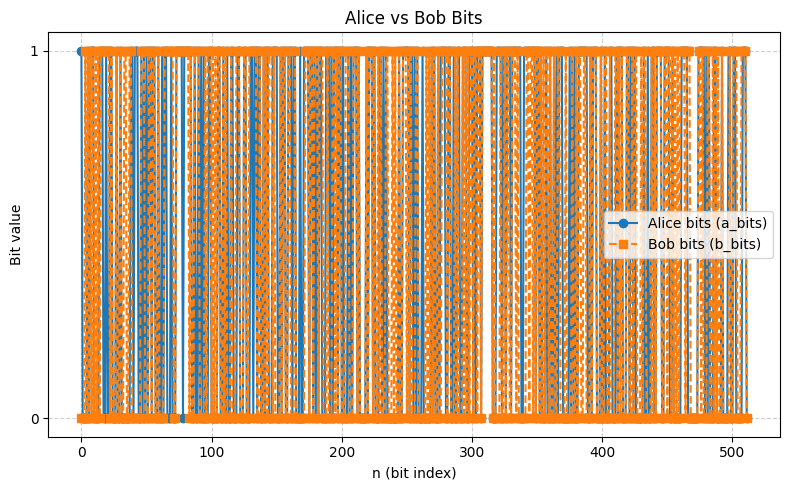

In [5]:
# Extract x (indices) and y (bit values)
x = list(a_bits.keys())
a_y = list(a_bits.values())
b_y = list(b_bits.values())

plt.figure(figsize=(8, 5))
plt.plot(x, a_y, 'o-', label='Alice bits (a_bits)')
plt.plot(x, b_y, 's--', label='Bob bits (b_bits)')

plt.title('Alice vs Bob Bits')
plt.xlabel('n (bit index)')
plt.ylabel('Bit value')
plt.yticks([0, 1])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

plt.show()

In [6]:
# Filter only where bases are equal
filtered_a_bits = {}
filtered_b_bits = {}

for i in range(len(a_base)):
    if a_base[i] == b_base[i]:
        filtered_a_bits[i] = a_bits[i]
        filtered_b_bits[i] = b_bits[i]

fa_bits = filtered_a_bits
fb_bits = filtered_b_bits

print("Filtered a_bits:", fa_bits)
print("Filtered b_bits:", fb_bits)
print("Number of matching bases:", len(fa_bits))

Filtered a_bits: {4: 0, 12: 0, 16: 1, 26: 0, 28: 0, 31: 0, 38: 1, 44: 0, 45: 0, 48: 1, 49: 0, 54: 0, 56: 1, 57: 0, 59: 1, 61: 0, 69: 1, 71: 0, 76: 1, 86: 0, 99: 1, 104: 0, 106: 1, 108: 0, 110: 0, 122: 0, 124: 0, 125: 1, 126: 1, 131: 1, 134: 1, 137: 1, 139: 0, 148: 1, 159: 1, 162: 0, 169: 0, 172: 1, 173: 1, 184: 1, 191: 0, 194: 1, 197: 0, 200: 0, 205: 1, 209: 1, 210: 1, 214: 0, 215: 0, 218: 0, 220: 0, 222: 1, 225: 1, 227: 0, 230: 1, 233: 0, 234: 1, 237: 0, 240: 0, 245: 0, 249: 1, 255: 0, 259: 0, 272: 0, 275: 0, 281: 0, 282: 1, 284: 0, 291: 0, 307: 0, 314: 1, 322: 1, 323: 0, 325: 1, 327: 1, 330: 0, 333: 1, 345: 1, 346: 1, 349: 0, 353: 1, 357: 1, 359: 0, 361: 0, 371: 0, 373: 0, 382: 1, 383: 1, 386: 1, 387: 1, 392: 0, 394: 1, 400: 0, 401: 0, 404: 0, 415: 1, 425: 1, 427: 0, 428: 0, 429: 0, 434: 0, 438: 1, 441: 0, 457: 0, 459: 0, 461: 1, 469: 0, 471: 0, 475: 1, 477: 1, 483: 0, 492: 1, 493: 0, 499: 0, 508: 1, 509: 1, 511: 0}
Filtered b_bits: {4: 0, 12: 0, 16: 1, 26: 0, 28: 0, 31: 0, 38: 1, 44

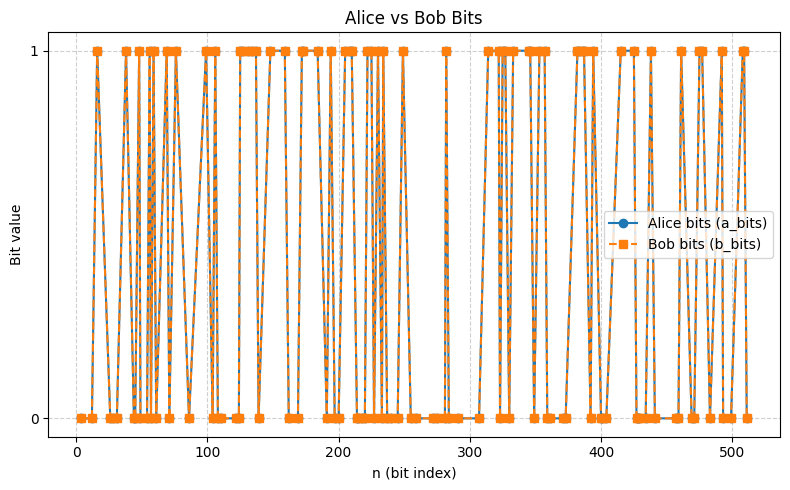

In [7]:
# Extract x (indices) and y (bit values)
x = list(fa_bits.keys())
a_y = list(fa_bits.values())
b_y = list(fb_bits.values())

plt.figure(figsize=(8, 5))
plt.plot(x, a_y, 'o-', label='Alice bits (a_bits)')
plt.plot(x, b_y, 's--', label='Bob bits (b_bits)')

plt.title('Alice vs Bob Bits')
plt.xlabel('n (bit index)')
plt.ylabel('Bit value')
plt.yticks([0, 1])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

plt.show()

Error analysis

In [8]:
e1=0
n1=0
e2=0
n2=0
e3=0
n3=0
e4=0
n4=0

# Iterate through the keys present in the filtered dictionaries
for i in range(n):
  if a_base[i]==0   and b_base[i]==1:
    n1=n1+1
    a11=a_bits[i]
    b11=b_bits[i]
    if (a11==0 and b11==0) or (a11==1 and b11==1):
      e1=e1+1
    else:
      e1=e1-1

  if a_base[i]==0 and b_base[i]==3:
    n2=n2+1
    a22=a_bits[i]
    b22=b_bits[i]
    if (a22==0 and b22==0) or (a22==1 and b22==1):
      e2=e2+1
    else:
      e2=e2-1

  if a_base[i]==2 and b_base[i]==1:
    n3=n3+1
    a33=a_bits[i]
    b33=b_bits[i]
    if (a33==0 and b33==0) or (a33==1 and b33==1):
      e3=e3+1
    else:
      e3=e3-1

  if a_base[i]==2 and b_base[i]==3:
    n4=n4+1
    a44=a_bits[i]
    b44=b_bits[i]
    if (a44==0 and b44==0) or (a44==1 and b44==1):
      e4=e4+1
    else:
      e4=e4-1

# Added checks to avoid division by zero if a base combination is not present
cor = 0
if n1 != 0:
  cor += e1/n1
if n2 != 0:
  cor -= e2/n2
if n3 != 0:
  cor += e3/n3
if n4 != 0:
  cor += e4/n4

print("The sum of corelation is",cor)
print("This is larger than 2 establishing the CHSH inequality for Entanglement without hidden variables")

The sum of corelation is 2.8815894797026873
This is larger than 2 establishing the CHSH inequality for Entanglement without hidden variables


## 2. E91 with eve

In [9]:
def transmission(a_base,b_base,e_base):
  qc=QuantumCircuit(3,3)
  qc.h(0)
  qc.cx(0,1)

  if a_base==1:
    qc.ry(np.pi/4,0)
  elif a_base==2:
    qc.ry(np.pi/2,0)

  if e_base==1:
    qc.ry(np.pi/4,1)
  elif e_base==2:
    qc.ry(np.pi/2,1)
  elif e_base==3:
    qc.ry(3*np.pi/4,1)
  p=qc.measure(1,2)

  if p==1:
    qc.x(2)
  if e_base==1:
    qc.ry(-np.pi/4,2)
  elif e_base==2:
    qc.ry(-np.pi/2,2)
  elif e_base==3:
    qc.ry(-3*np.pi/4,2)

  if b_base==1:
    qc.ry(np.pi/4,2)
  elif b_base==2:
    qc.ry(np.pi/2,2)
  elif b_base==3:
    qc.ry(3*np.pi/4,2)

  qc.measure(0,0)
  qc.measure(2,1)

  return qc

In [10]:
n=512

a_base=[np.random.randint(0,3) for i in range(n)]
b_base=[np.random.randint(1,4) for i in range(n)]
e_base=[np.random.randint(0,4) for i in range(n)]

b_bits={}
a_bits={}

# Create simulator and sampler once
sim_backend = AerSimulator()
pm = generate_preset_pass_manager(backend=sim_backend, optimization_level=1)
sampler = Sampler(mode=sim_backend)

for i in range(n):
    isa_qc = pm.run(transmission(a_base[i], b_base[i],e_base[i]))
    job = sampler.run([isa_qc], shots=1)
    result = job.result()
    counts = result[0].data.c.get_counts()
    first_key = list(counts.keys())[0]
    a_bits[i] = int(first_key)%10
    b_bits[i] = int(((int(first_key)-a_bits[i])/10)%10)

print(a_bits)
print(b_bits)


diff_count = sum(1 for i in a_bits if a_bits[i] != b_bits[i])
print("fraction of bits which are not same for Alice and BoB=",diff_count/n)

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 1, 8: 1, 9: 0, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0, 20: 0, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 0, 27: 0, 28: 1, 29: 0, 30: 1, 31: 1, 32: 1, 33: 0, 34: 1, 35: 1, 36: 0, 37: 1, 38: 1, 39: 0, 40: 1, 41: 1, 42: 1, 43: 0, 44: 1, 45: 0, 46: 1, 47: 0, 48: 1, 49: 1, 50: 0, 51: 0, 52: 1, 53: 0, 54: 1, 55: 1, 56: 0, 57: 0, 58: 1, 59: 0, 60: 0, 61: 1, 62: 1, 63: 1, 64: 0, 65: 1, 66: 1, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 1, 74: 1, 75: 0, 76: 0, 77: 1, 78: 1, 79: 0, 80: 0, 81: 0, 82: 1, 83: 1, 84: 0, 85: 0, 86: 1, 87: 1, 88: 1, 89: 0, 90: 1, 91: 1, 92: 1, 93: 1, 94: 0, 95: 1, 96: 0, 97: 1, 98: 0, 99: 0, 100: 1, 101: 1, 102: 0, 103: 1, 104: 0, 105: 1, 106: 1, 107: 0, 108: 1, 109: 0, 110: 0, 111: 0, 112: 1, 113: 1, 114: 1, 115: 0, 116: 0, 117: 0, 118: 0, 119: 1, 120: 1, 121: 1, 122: 1, 123: 0, 124: 0, 125: 1, 126: 0, 127: 0, 128: 0, 129: 0, 130: 1, 131: 1, 132: 1, 133: 0, 134: 0, 135: 1, 136: 0, 137: 1, 138: 

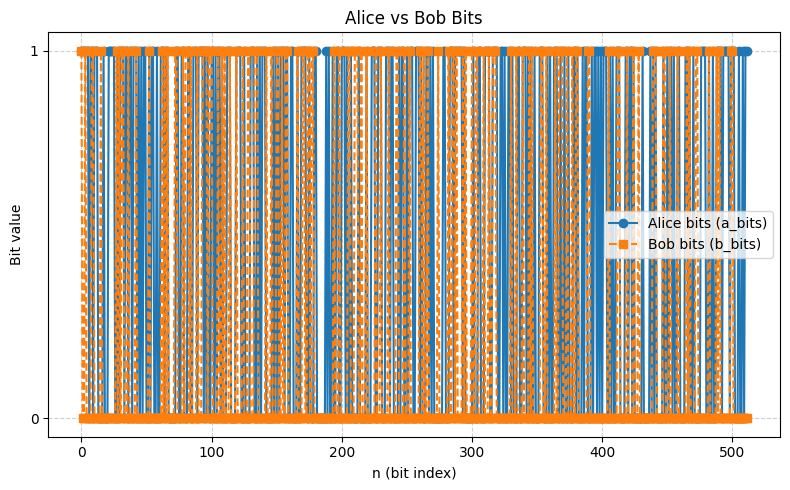

In [11]:
# Extract x (indices) and y (bit values)
x = list(a_bits.keys())
a_y = list(a_bits.values())
b_y = list(b_bits.values())

plt.figure(figsize=(8, 5))
plt.plot(x, a_y, 'o-', label='Alice bits (a_bits)')
plt.plot(x, b_y, 's--', label='Bob bits (b_bits)')

plt.title('Alice vs Bob Bits')
plt.xlabel('n (bit index)')
plt.ylabel('Bit value')
plt.yticks([0, 1])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

plt.show()

In [12]:
# Filter only where bases are equal
filtered_a_bits = {}
filtered_b_bits = {}

for i in range(len(a_base)):
    if a_base[i] == b_base[i]:
        filtered_a_bits[i] = a_bits[i]
        filtered_b_bits[i] = b_bits[i]

fa_bits = filtered_a_bits
fb_bits = filtered_b_bits

print("Filtered a_bits:", fa_bits)
print("Filtered b_bits:", fb_bits)
print("Number of matching bases:", len(fa_bits))

Filtered a_bits: {0: 1, 8: 1, 10: 1, 13: 0, 16: 0, 17: 1, 18: 0, 19: 0, 21: 1, 30: 1, 38: 1, 44: 1, 48: 1, 49: 1, 50: 0, 55: 1, 57: 0, 61: 1, 62: 1, 65: 1, 70: 0, 77: 1, 85: 0, 88: 1, 97: 1, 103: 1, 106: 1, 121: 1, 129: 0, 133: 0, 134: 0, 137: 1, 141: 1, 165: 0, 166: 1, 167: 0, 168: 0, 173: 0, 175: 1, 177: 0, 181: 0, 186: 0, 187: 0, 189: 0, 190: 1, 196: 1, 200: 1, 203: 0, 208: 0, 213: 1, 214: 0, 216: 0, 219: 1, 222: 0, 230: 1, 231: 0, 238: 1, 240: 0, 241: 0, 242: 0, 249: 0, 251: 0, 252: 1, 257: 1, 258: 1, 259: 1, 268: 1, 272: 0, 276: 0, 283: 1, 289: 1, 290: 1, 297: 0, 302: 0, 310: 1, 314: 0, 320: 0, 324: 0, 326: 0, 330: 0, 335: 1, 340: 1, 343: 1, 347: 0, 348: 1, 350: 0, 357: 0, 361: 0, 375: 0, 386: 0, 387: 1, 393: 0, 402: 1, 403: 1, 412: 1, 413: 1, 414: 0, 415: 0, 417: 0, 418: 1, 421: 1, 429: 0, 432: 0, 436: 0, 438: 0, 439: 1, 445: 0, 449: 0, 454: 0, 457: 0, 459: 1, 464: 1, 472: 0, 475: 0, 489: 1, 507: 0, 508: 1}
Filtered b_bits: {0: 1, 8: 1, 10: 0, 13: 0, 16: 0, 17: 0, 18: 0, 19: 0, 2

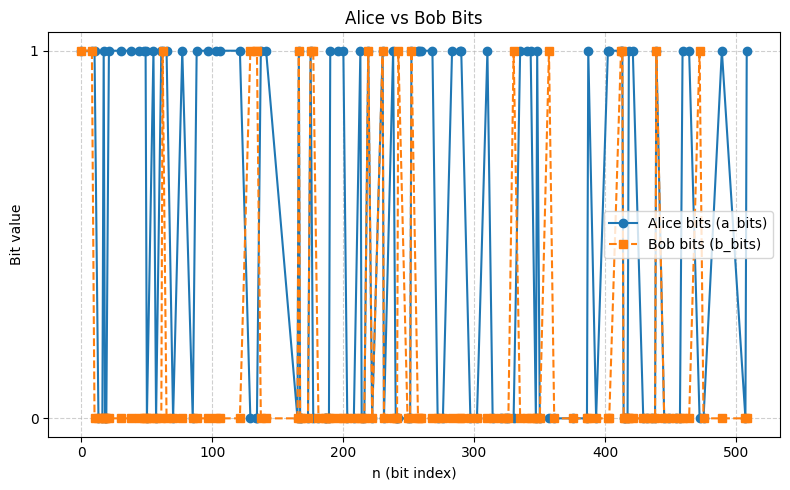

In [13]:
# Extract x (indices) and y (bit values)
x = list(fa_bits.keys())
a_y = list(fa_bits.values())
b_y = list(fb_bits.values())

plt.figure(figsize=(8, 5))
plt.plot(x, a_y, 'o-', label='Alice bits (a_bits)')
plt.plot(x, b_y, 's--', label='Bob bits (b_bits)')

plt.title('Alice vs Bob Bits')
plt.xlabel('n (bit index)')
plt.ylabel('Bit value')
plt.yticks([0, 1])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

plt.show()

In [14]:
e1=0
n1=0
e2=0
n2=0
e3=0
n3=0
e4=0
n4=0


# Iterate through the keys present in the filtered dictionaries
for i in range(n):
  if a_base[i]==0   and b_base[i]==1:
    n1=n1+1
    a11=a_bits[i]
    b11=b_bits[i]
    if (a11==0 and b11==0) or (a11==1 and b11==1):
      e1=e1+1
    else:
      e1=e1-1

  if a_base[i]==0 and b_base[i]==3:
    n2=n2+1
    a22=a_bits[i]
    b22=b_bits[i]
    if (a22==0 and b22==0) or (a22==1 and b22==1):
      e2=e2+1
    else:
      e2=e2-1

  if a_base[i]==2 and b_base[i]==1:
    n3=n3+1
    a33=a_bits[i]
    b33=b_bits[i]
    if (a33==0 and b33==0) or (a33==1 and b33==1):
      e3=e3+1
    else:
      e3=e3-1

  if a_base[i]==2 and b_base[i]==3:
    n4=n4+1
    a44=a_bits[i]
    b44=b_bits[i]
    if (a44==0 and b44==0) or (a44==1 and b44==1):
      e4=e4+1
    else:
      e4=e4-1

# Added checks to avoid division by zero if a base combination is not present
cor = 0
if n1 != 0:
  cor += e1/n1
if n2 != 0:
  cor -= e2/n2
if n3 != 0:
  cor += e3/n3
if n4 != 0:
  cor += e4/n4

print("The sum of corelation is",cor)
print("This is lesser than 2 establishing the presence of Eve who breaks the entanglement.")

The sum of corelation is -0.28787878787878785
This is lesser than 2 establishing the presence of Eve who breaks the entanglement.


## E91 With error

In [15]:
def transmission(a_base,b_base):
  qc=QuantumCircuit(2,2)
  qc.h(0)
  qc.cx(0,1)

  if a_base==1:
    qc.ry(np.pi/4,0)
  elif a_base==2:
    qc.ry(np.pi/2,0)

  if b_base==1:
    qc.ry(np.pi/4,1)
  elif b_base==2:
    qc.ry(np.pi/2,1)
  elif b_base==3:
    qc.ry(3*np.pi/4,1)

  qc.measure(0,0)
  qc.measure(1,1)

  return qc

E91 with Photon loss

In [16]:
n =512
noise_prob = 0.05 #5%noise

#Random bits and bases
a_base = [np.random.randint(0, 3) for i in range(n)]
b_base = [np.random.randint(1, 4) for i in range(n)]

noise_model = NoiseModel()

# Gate noise (depolarizing)
dep_error = depolarizing_error(noise_prob, 1)
noise_model.add_all_qubit_quantum_error(dep_error, ['x', 'h'])

# Measurement noise (bit flip)
meas_error = pauli_error([('X', noise_prob), ('I', 1 - noise_prob)])
noise_model.add_all_qubit_quantum_error(meas_error, ['measure'])

#photon noise
photon_loss_prob = 0.03  # 3% photon loss probability

# Build noisy simulator
sim_backend = AerSimulator(noise_model=noise_model)
pm = generate_preset_pass_manager(backend=sim_backend, optimization_level=1)
sampler = Sampler(mode=sim_backend)

#Run simulation
b_bits = {}
a_bits = {}


for i in range(n):
    a_flag=True
    b_flag=True

    # simulate photon loss at classical level
    if np.random.rand() < photon_loss_prob:
        b_bits[i] = None
        b_flag=False

    # simulate photon loss at quantum level
    if np.random.rand() < photon_loss_prob:
        a_bits[i] = None
        a_flag=False

    isa_qc = pm.run(transmission( a_base[i], b_base[i]))
    job = sampler.run([isa_qc], shots=1)
    result = job.result()
    counts = result[0].data.c.get_counts()
    first_key = list(counts.keys())[0]

    if(a_flag and b_flag): #no photon loss in both
      b_bits[i] = int(first_key)%10
      a_bits[i] = int(first_key)//10
    elif(a_flag): #no photon loss with BOB
      b_bits[i] = int(first_key)%10
      a_bits[i] = None
    elif(b_flag): #no photon loss with Alice
      b_bits[i] = None
      a_bits[i] = int(first_key)//10

print(a_bits)
print(b_bits)

valid_indices = [i for i in a_bits if a_bits[i] is not None and b_bits[i] is not None]
diff_count = sum(1 for i in valid_indices if a_bits[i] != b_bits[i])
print("No of mismatched bits (before basis filtering):", diff_count)
print("Total valid detections:", len(valid_indices))
print("Total losses:", n - len(valid_indices))

{0: 1, 1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: None, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: None, 16: 1, 17: 0, 18: 1, 19: 0, 20: 0, 21: 1, 22: 1, 23: 0, 24: 0, 25: 0, 26: 1, 27: 1, 28: 1, 29: 1, 30: 0, 31: 1, 32: 0, 33: 1, 34: 1, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 1, 43: 0, 44: 1, 45: 1, 46: 1, 47: 0, 48: 1, 49: 1, 50: 0, 51: 1, 52: 1, 53: 1, 54: 0, 55: 1, 56: 0, 57: 1, 58: 0, 59: None, 60: 1, 61: 0, 62: 0, 63: 0, 64: 0, 65: None, 66: 0, 67: 1, 68: 1, 69: 1, 70: 0, 71: 0, 72: 0, 73: 1, 74: 0, 75: 1, 76: 0, 77: 0, 78: 1, 79: 1, 80: 0, 81: 0, 82: 1, 83: 1, 84: 1, 85: 0, 86: 1, 87: 0, 88: 0, 89: 0, 90: 1, 91: 1, 92: 1, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 1, 99: 1, 100: 0, 101: 1, 102: 1, 103: 0, 104: 0, 105: 0, 106: 0, 107: 1, 108: 0, 109: 1, 110: 1, 111: 1, 112: 0, 113: 1, 114: 0, 115: 0, 116: 0, 117: 1, 118: 0, 119: 1, 120: 0, 121: 1, 122: 0, 123: 1, 124: 1, 125: 0, 126: 1, 127: 1, 128: 0, 129: 0, 130: 0, 131: 1, 132: 0, 133: 1, 134: 0, 135: 0, 136: 1, 1

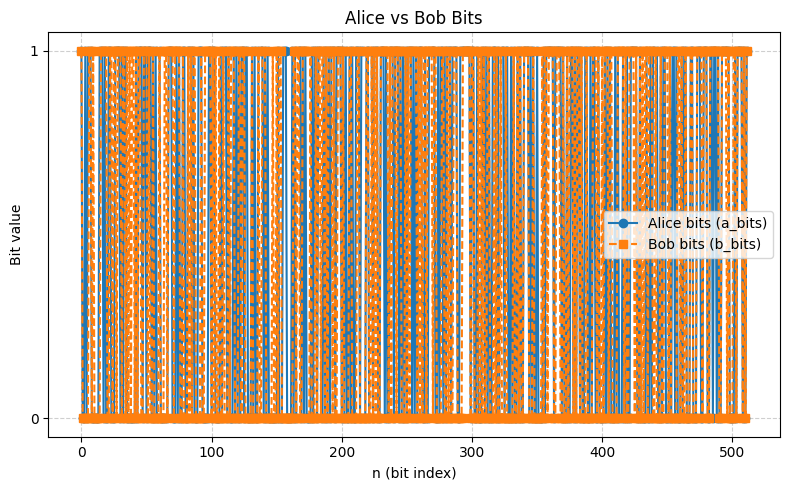

In [17]:
# Extract x (indices) and y (bit values)
x = list(a_bits.keys())
a_y = list(a_bits.values())
b_y = list(b_bits.values())

plt.figure(figsize=(8, 5))
plt.plot(x, a_y, 'o-', label='Alice bits (a_bits)')
plt.plot(x, b_y, 's--', label='Bob bits (b_bits)')

plt.title('Alice vs Bob Bits')
plt.xlabel('n (bit index)')
plt.ylabel('Bit value')
plt.yticks([0, 1])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

plt.show()

In [18]:
# Filter only where bases are equal
filtered_a_bits = {}
filtered_b_bits = {}
matching_indices=[]

for i in range(len(a_base)):
    if a_base[i] == b_base[i]:
        filtered_a_bits[i] = a_bits[i]
        filtered_b_bits[i] = b_bits[i]
        matching_indices.append(i)

fa_bits = filtered_a_bits
fb_bits = filtered_b_bits

print("Filtered a_bits:", fa_bits)
print("Filtered b_bits:", fb_bits)
print("Number of matching bases:", len(fa_bits))

diff_count = sum(1 for i in fa_bits if fa_bits[i] != fb_bits[i])
print("No of mismatched bits (before basis filtering):", diff_count )

Filtered a_bits: {12: 0, 15: None, 18: 1, 26: 1, 33: 1, 42: 1, 44: 1, 45: 1, 55: 1, 60: 1, 66: 0, 75: 1, 77: 0, 80: 0, 92: 1, 100: 0, 101: 1, 113: 1, 116: 0, 117: 1, 121: 1, 129: 0, 132: 0, 133: 1, 137: None, 139: 1, 142: 0, 145: 0, 148: 0, 156: 1, 158: 0, 180: 1, 183: 1, 190: 1, 192: 1, 195: 0, 197: 1, 198: 1, 200: 0, 204: 0, 208: 1, 209: 0, 214: 0, 221: 0, 222: None, 235: 0, 237: 1, 241: 1, 245: 1, 256: 0, 260: 1, 261: 1, 264: 1, 265: 0, 280: 0, 288: 1, 290: 0, 295: 1, 296: 1, 299: 0, 300: 1, 303: 0, 306: 0, 309: 1, 312: 0, 328: 0, 329: 0, 330: 1, 331: 0, 333: 0, 334: 0, 341: 1, 343: 1, 344: 0, 346: 0, 351: 0, 353: 0, 357: 1, 359: 1, 366: 1, 369: 0, 372: 0, 373: 1, 376: 1, 377: 1, 378: 0, 384: 1, 386: 0, 388: 1, 394: 1, 396: 0, 404: 1, 405: 0, 406: 1, 413: 0, 415: 0, 421: 0, 422: 1, 423: 1, 424: 1, 428: 0, 442: 1, 446: 0, 448: 1, 451: 0, 453: 0, 461: 1, 465: 0, 468: 1, 471: 0, 472: 0, 474: 1, 476: 0, 480: 1, 483: 1, 492: 1, 502: 1, 507: 1}
Filtered b_bits: {12: 0, 15: 1, 18: 1, 26: 1

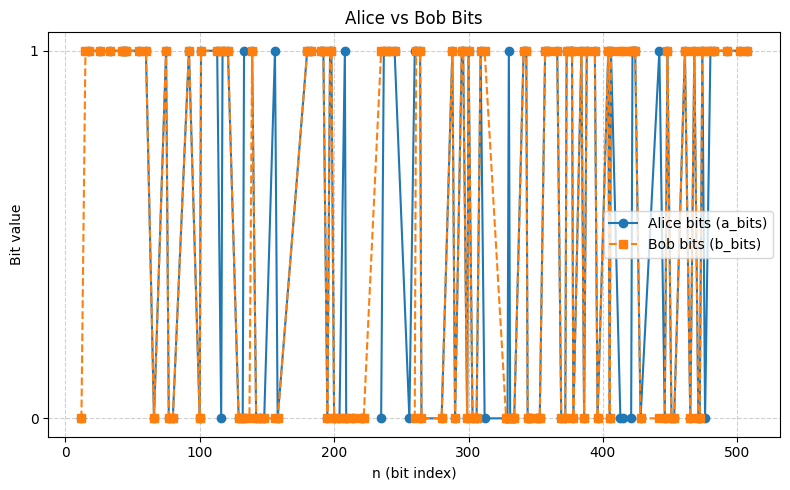

In [19]:
# Extract x (indices) and y (bit values)
x = list(fa_bits.keys())
a_y = list(fa_bits.values())
b_y = list(fb_bits.values())

plt.figure(figsize=(8, 5))
plt.plot(x, a_y, 'o-', label='Alice bits (a_bits)')
plt.plot(x, b_y, 's--', label='Bob bits (b_bits)')

plt.title('Alice vs Bob Bits')
plt.xlabel('n (bit index)')
plt.ylabel('Bit value')
plt.yticks([0, 1])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

plt.show()

In [20]:
e1=0
n1=0
e2=0
n2=0
e3=0
n3=0
e4=0
n4=0

# Iterate through the keys present in the filtered dictionaries
for i in range(n):
  if a_base[i]==0   and b_base[i]==1:
    n1=n1+1
    a11=a_bits[i]
    b11=b_bits[i]
    if (a11==0 and b11==0) or (a11==1 and b11==1):
      e1=e1+1
    else:
      e1=e1-1

  if a_base[i]==0 and b_base[i]==3:
    n2=n2+1
    a22=a_bits[i]
    b22=b_bits[i]
    if (a22==0 and b22==0) or (a22==1 and b22==1):
      e2=e2+1
    else:
      e2=e2-1

  if a_base[i]==2 and b_base[i]==1:
    n3=n3+1
    a33=a_bits[i]
    b33=b_bits[i]
    if (a33==0 and b33==0) or (a33==1 and b33==1):
      e3=e3+1
    else:
      e3=e3-1

  if a_base[i]==2 and b_base[i]==3:
    n4=n4+1
    a44=a_bits[i]
    b44=b_bits[i]
    if (a44==0 and b44==0) or (a44==1 and b44==1):
      e4=e4+1
    else:
      e4=e4-1

# Added checks to avoid division by zero if a base combination is not present
cor = 0
if n1 != 0:
  cor += e1/n1
if n2 != 0:
  cor -= e2/n2
if n3 != 0:
  cor += e3/n3
if n4 != 0:
  cor += e4/n4

print("The sum of corelation is",cor)
print("This is larger than 2 establishing the CHSH inequality for Entanglement, even in the presence of noisy channel ")

The sum of corelation is 2.311602557383922
This is larger than 2 establishing the CHSH inequality for Entanglement, even in the presence of noisy channel 


Actual QBER = 0.1140
Actual bits with errors = 13

Average estimated QBER = 0.1174 ± 0.0304 (std over 200 runs)


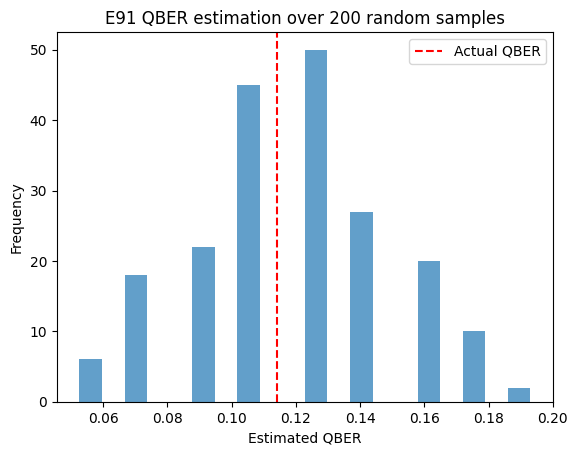

In [21]:
#QBER estimation for E91 protocol

subset = 0.5  # 50% of matching bits used for estimation
sample_size = int(subset * len(matching_indices))

#Compute actual QBER (theoretical true error rate)
# In E91, mismatched bits (when both measure in correlated bases) indicate error
actual_qber = sum(
    (fa_bits[i] is not None and fb_bits[i] is not None and fa_bits[i] != fb_bits[i])
    for i in matching_indices
) / len([i for i in matching_indices if fa_bits[i] is not None and fb_bits[i] is not None])

print(f"Actual QBER = {actual_qber:.4f}")
print("Actual bits with errors =",
      sum(fa_bits[i] != fb_bits[i] for i in matching_indices
          if fa_bits[i] is not None and fb_bits[i] is not None))

#Random sampling to simulate public subset announcement
num_trials = 200
estimates = []

valid_indices = [i for i in matching_indices if fa_bits[i] is not None and fb_bits[i] is not None]
sample_size = int(subset * len(valid_indices))

for _ in range(num_trials):
    sample_indices = random.sample(valid_indices, sample_size)
    qber_estimate = sum(fa_bits[i] != fb_bits[i] for i in sample_indices) / sample_size
    estimates.append(qber_estimate)

mean_estimate = np.mean(estimates)
std_estimate = np.std(estimates)

print(f"\nAverage estimated QBER = {mean_estimate:.4f} ± {std_estimate:.4f} (std over {num_trials} runs)")

#Plot QBER estimation variability
plt.hist(estimates, bins=20, alpha=0.7)
plt.axvline(actual_qber, color='red', linestyle='--', label='Actual QBER')
plt.title(f"E91 QBER estimation over {num_trials} random samples")
plt.xlabel("Estimated QBER")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [22]:
#Bob and Alice remove corresponding photon losses
lost_indices = [i for i in matching_indices if fa_bits[i] is None or fb_bits[i] is None]

# Remove lost bits from both sides
for i in lost_indices:
    fa_bits.pop(i, None)
    fb_bits.pop(i, None)

# Valid indices after loss reconciliation
valid_indices = [i for i in matching_indices if i not in lost_indices]
print(f"After photon loss reconciliation, valid bits: {len(valid_indices)} / {len(matching_indices)}")

#Alice announces a random subset of bits to Bob for QBER estimation
subset = 0.5  # 50% of bits used for estimation
sample_size = int(subset * len(valid_indices))
sample_indices = random.sample(valid_indices, sample_size)

# Calculate QBER estimate based on public subset
qber_estimate = sum(fa_bits[i] != fb_bits[i] for i in sample_indices) / sample_size
print(f"Estimated QBER (from public subset): {qber_estimate:.4f}")

# Remove publicly revealed sample bits from both sides
for i in sample_indices:
    fa_bits.pop(i, None)
    fb_bits.pop(i, None)

#Construct final secret keys
remaining_indices = sorted(fa_bits.keys())
A_keys = [fa_bits[i] for i in remaining_indices]
B_keys = [fb_bits[i] for i in remaining_indices]

print(f"\nRemaining bits after QBER estimation: {len(A_keys)}")
print("Alice's final key:", A_keys)
print("Bob's final key:  ", B_keys)

After photon loss reconciliation, valid bits: 114 / 118
Estimated QBER (from public subset): 0.1404

Remaining bits after QBER estimation: 57
Alice's final key: [0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1]
Bob's final key:   [0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1]


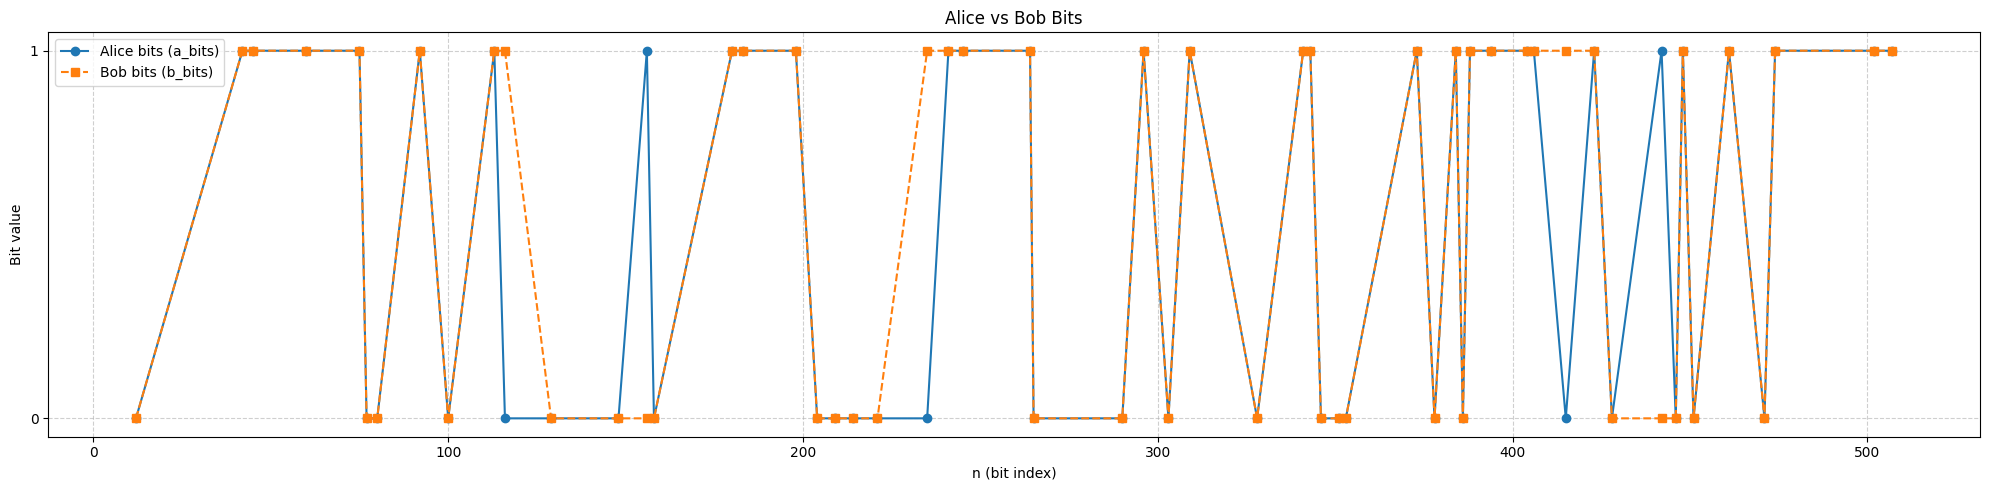

In [23]:
# Extract x (indices) and y (bit values)
x = list(fa_bits.keys())
a_y = list(fa_bits.values())
b_y = list(fb_bits.values())

plt.figure(figsize=(20, 5))
plt.plot(x, a_y, 'o-', label='Alice bits (a_bits)')
plt.plot(x, b_y, 's--', label='Bob bits (b_bits)')

plt.title('Alice vs Bob Bits')
plt.xlabel('n (bit index)')
plt.ylabel('Bit value')
plt.yticks([0, 1])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

plt.show()

In [24]:
def cascade(A_key, B_key):

    N = len(A_key)
    B_key = B_key.copy()  # avoid in-place modification of input

    #Divide into blocks
    B_size = int(1/qber_estimate)  # block size
    blocks_A = []
    blocks_B = []

    for start in range(0, len(A_key), B_size):
        end = start + B_size
        blocks_A.append(A_key[start:end])
        blocks_B.append(B_key[start:end])
    parity_A=[(sum(i))%2 for i in blocks_A]
    parity_B=[(sum(i)%2) for i in blocks_B]
        #If mismatch, binary search within the block
    for i in range(len(parity_A)):
        if parity_A[i] != parity_B[i]:
            left, right = 0, len(blocks_B[i])
            while left < right:
                mid = (left + right) // 2
                pA = sum(blocks_A[i][left:mid+1]) % 2
                pB = sum(blocks_B[i][left:mid+1]) % 2
                if pA != pB:
                    right = mid  # error is in left half
                else:
                    left = mid + 1  # error is in right half

            B_key[left] = A_key[left]
    return B_key

In [25]:
import random

# assume you already have A_key and B_key from sifting
b_1=B_keys.copy()

for i in range(1000):
    indices = list(range(len(A_keys)))
    random.shuffle(indices)

    #Apply the same permutation
    A_shuffled = [A_keys[j] for j in indices]
    B_shuffled = [b_1[j] for j in indices]

    #Run Cascade on shuffled keys
    corrected_shuffled = cascade(A_shuffled, B_shuffled)

    #Unshuffle back to original order
    unshuffled = [0] * len(A_keys)
    for new_pos, old_pos in enumerate(indices):
        unshuffled[old_pos] = corrected_shuffled[new_pos]

    #Update b for next pass
    b_1 = unshuffled

# After all passes:
print("Final corrected key:", b_1)
print("Errors remaining:", sum(x != y for x, y in zip(A_keys, b_1)))
print("Length of key is",len(b_1))

Final corrected key: [0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1]
Errors remaining: 0
Length of key is 57


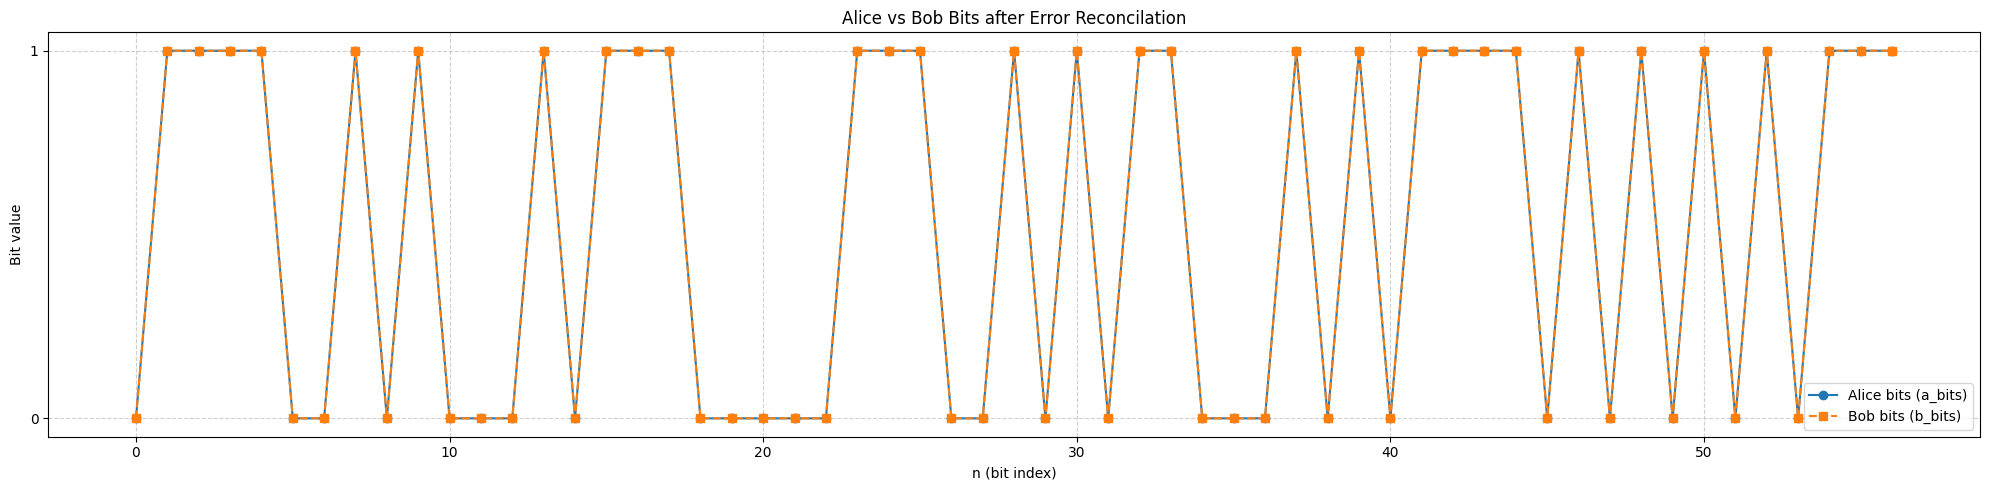

In [26]:
x = [i for i in range(len(A_keys))]
a_y = A_keys
b_y = b_1

plt.figure(figsize=(20, 5))
plt.plot(x, a_y, 'o-', label='Alice bits (a_bits)')
plt.plot(x, b_y, 's--', label='Bob bits (b_bits)')

plt.title('Alice vs Bob Bits after Error Reconcilation')
plt.xlabel('n (bit index)')
plt.ylabel('Bit value')
plt.yticks([0, 1])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

plt.show()